## Code for testing the influence of different shapes on the K function

In [1]:
from spatial_statistics_tools import *

# specify directory
dir_ = "/Users/lukasjudith/Documents/Studium/Master Physik Heidelberg/Semester 2/01 HCI project/Code/spatial-statistical-analysis"
os.chdir(dir_)

In [2]:
def create_ellipsis(N, dimx=512, ratio=1, x_shift=0, y_shift=0, N_missing=0, N_holes=0, intensity=1, is_hole=False):
    """
    Creates dimx by dimx array of zeros with an ellipse of ones. The ellipse can have a specified number of holes.
    
    Args:
        bool is_hole: ...
        ...
    """

    if N_missing>0 and N_holes>0:
        N_tot = N + N_missing
    else:
        N_tot = N

    # number pixels is equal to area N = np.pi * a * b
    # N = np.pi * a**2 * ratio 
    a = np.sqrt(N_tot / (np.pi * ratio))
    b = ratio * a

    
    dimx = 512
    half_dim = int((dimx)/2)

    x_range = list(abs(np.arange(-half_dim-x_shift, half_dim-x_shift)))
    y_range = list(abs(np.arange(-half_dim-y_shift, half_dim-y_shift)))

    # array where every element is x distance from center
    diff_x = np.array([x_range, ]*dimx)

    # array where every element is y distance from center
    diff_y = np.array([y_range, ]*dimx).T

    diff_xy = np.sqrt((diff_x/a)**2 + (diff_y/b)**2)

    out_array = np.zeros((dimx, dimx))
    out_array[diff_xy<=1] = 1
        
    if N_missing>0 and N_holes>0:
        
        missing_per_hole = int(N_missing/N_holes)
        
        for i in range(N_holes):
            
            old_out = np.array([-1])
            
            # counting iterations to avoid infinite loop
            count = 0
            max_iter = 30
    
            while -1 in old_out:
            
                count +=1
                if count > max_iter:
                    raise Exception("Too many iterations! Could not place holes successfully. Try reducing number of holes or number of pixels in holes.")
                            
                old_out = out_array.copy()

                x_pos = np.random.randint(low=-int(a), high=int(a), size=1)[0]
                y_pos = np.random.randint(low=-int(b), high=int(b), size=1)[0]
                
                hole = create_ellipsis(N=missing_per_hole, dimx=dimx, x_shift=x_shift+x_pos, y_shift=y_shift+y_pos, N_missing=0, intensity=1, is_hole=True)

                old_out = old_out - hole
            
            # overwrite using the new version with hole
            out_array = old_out    

    if not is_hole:
        actual_number = np.sum(out_array)
        wanted_number = N 
        number_deviation = abs(wanted_number - actual_number) / wanted_number

        if number_deviation > 0.005:
            print(f"Actual number: {actual_number}; wanted number: {wanted_number}; deviation: {number_deviation}")
            raise Exception("Number of actual pixels in ellipse is much lower than the desired number!")
  
    out_array = out_array * intensity
    
    return out_array


## Test behavour of Ripley's K function on toy dataset

In [3]:
N = 50000
# average intensity
intensity = 3000

### Dataset 1: Ellipses with different eccentricities

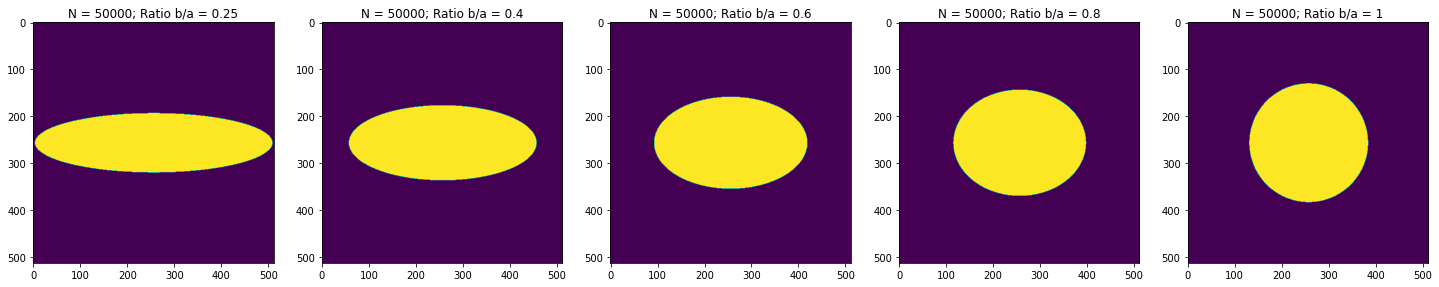

In [4]:
dataset1 = []

ratio_range = [0.25, 0.4, 0.6, 0.8, 1]

for ratio in ratio_range:
    ellipse = create_ellipsis(N=50000, ratio=ratio, intensity=intensity)
    dataset1.append(ellipse)

fig, ax = plt.subplots(1,5, figsize=(25, 5))

for i in range(len(ratio_range)):
    
    ratio = ratio_range[i]
    ell = dataset1[i]
    ax[i].imshow(ell)
    ax[i].set_title(f"N = {N}; Ratio b/a = {ratio}")
    
plt.savefig("Dataset1.pdf")
plt.show()

Completed in 0.70 seconds
Completed in 0.60 seconds
Completed in 0.62 seconds
Completed in 0.60 seconds
Completed in 0.60 seconds


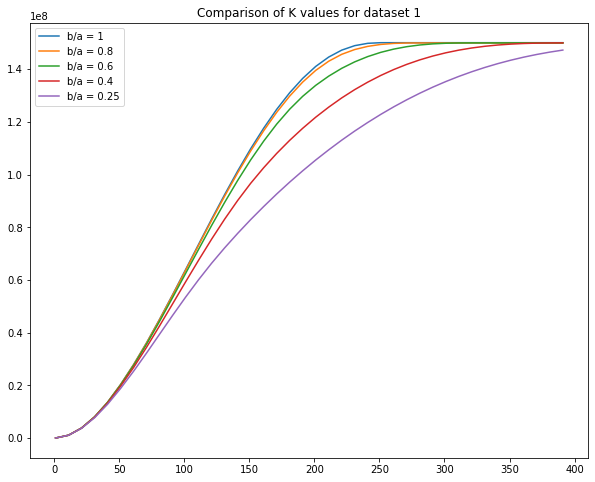

In [5]:
range_of_t = np.arange(1, 400, 10)

plt.figure(figsize=(10,8))
plt.title("Comparison of K values for dataset 1")

for i in reversed(range(len(ratio_range))):

    ratio = ratio_range[i]  # ratio of b and a axes of ellipse
    ell_img = dataset1[i]  # img of the ellipse

    K_values_cell = ripleys_K_fast(ell_img, range_of_t)
    plt.plot(range_of_t, K_values_cell, label=f"b/a = {ratio}")
    
plt.legend()
plt.savefig("Kfunctions1.pdf")
plt.show()  

### Dataset 2: Ellipses with holes of different sizes

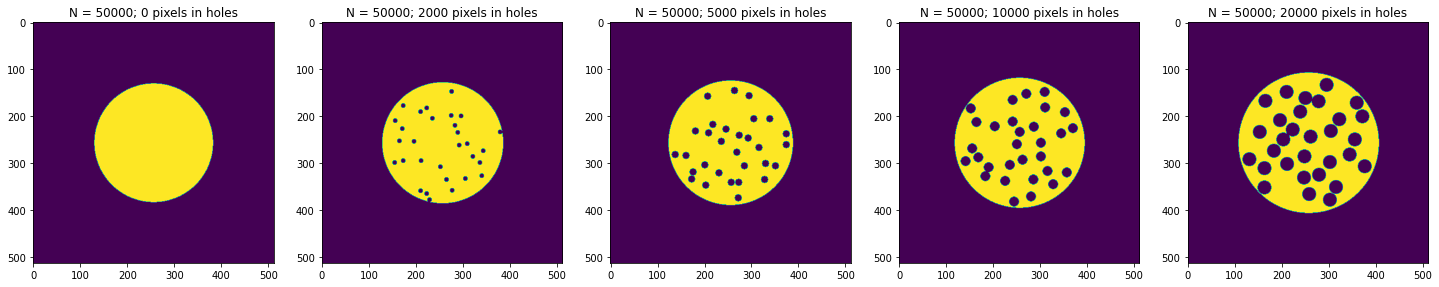

In [6]:
dataset2 = []

N_holes = 30
N_missing_range = [0, 2000, 5000, 10000, 20000]
#N_missing_range = [10000]

for N_missing in N_missing_range:
    ellipse = create_ellipsis(N=50000, N_holes=N_holes, N_missing=N_missing, intensity=intensity)
    dataset2.append(ellipse)

fig, ax = plt.subplots(1,5, figsize=(25, 5))


for i in range(len(N_missing_range)):
    
    N_missing = N_missing_range[i]
    ell = dataset2[i]
    ax[i].imshow(ell)
    ax[i].set_title(f"N = {N}; {N_missing} pixels in holes")
plt.savefig("dataset2.pdf")
plt.show()

Completed in 0.69 seconds
Completed in 0.61 seconds
Completed in 0.61 seconds
Completed in 0.61 seconds
Completed in 0.61 seconds


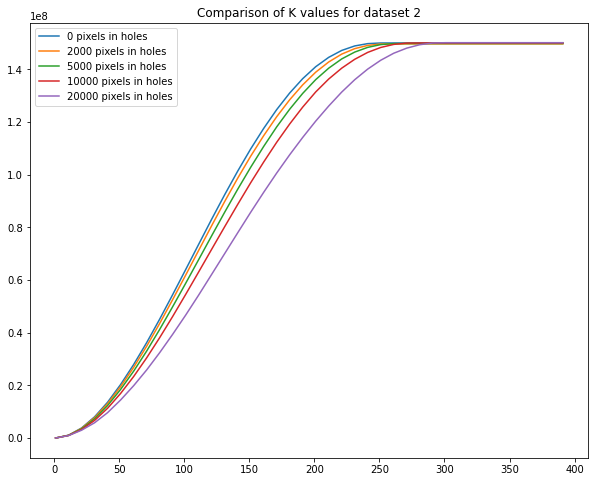

In [7]:
range_of_t = np.arange(1, 400, 10)

plt.figure(figsize=(10,8))
plt.title("Comparison of K values for dataset 2")

for i in range(len(N_missing_range)):
    
    N_missing = N_missing_range[i]  # ratio of b and a axes of ellipse
    ell_img = dataset2[i]  # img of the ellipse
    
    K_values_cell = ripleys_K_fast(ell_img, range_of_t)
    plt.plot(range_of_t, K_values_cell, label=f"{N_missing} pixels in holes")
    
plt.legend()
plt.savefig("Kfunctions2.pdf")
plt.show()  

## Other tests

In [28]:
def create_n_ellipses(N_tot=50000, intensity=3000, number_ellipses=5, max_count=100):
    """
    Creates specified number of standard disks in random places.
    """

    N_small = int(N_tot/number_ellipses)

    count = 0

    ell = np.zeros(10)
    while np.max(ell) != intensity:
        # avoid infinite loops
        count += 1
        if count > max_count:
            raise Exception("Loop ended after maximum number of iterations! Try increasing max_count or lowering number_ellipses.")
            
        ell = 0
        for i in range(number_ellipses):
            # TODO: change hardcoded boundaries for the random shifts
            ell = ell + create_ellipsis(N=N_small, intensity=intensity, x_shift=np.random.randint(-150,150), y_shift=np.random.randint(-150,150))

    return ell

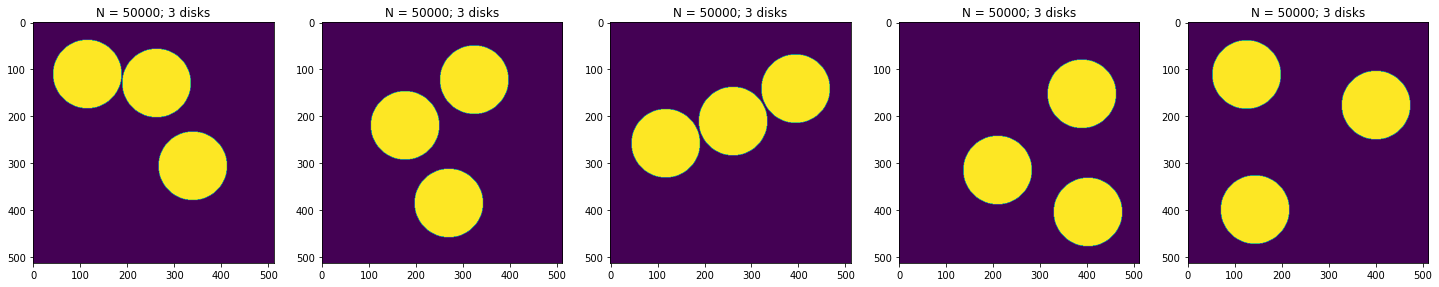

Completed in 0.69 seconds
Completed in 0.60 seconds
Completed in 0.60 seconds
Completed in 0.63 seconds
Completed in 0.61 seconds


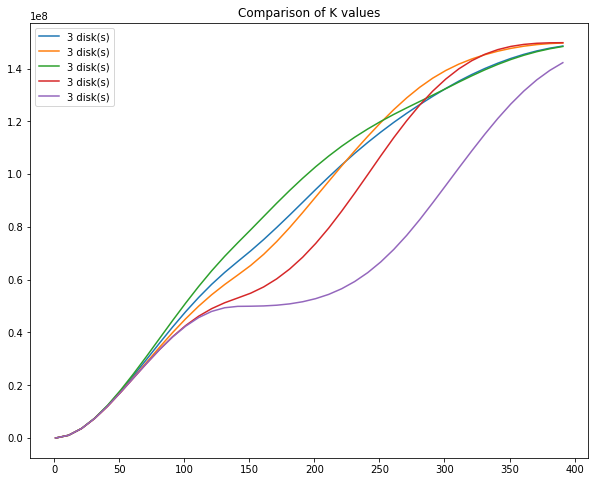

In [70]:
N1 = 50000
intensity = 3000

dataset3 = []

fig, ax = plt.subplots(1,5, figsize=(25, 5))

numbers = [3,3,3,3,3]

for i in range(len(numbers)):
    
    number = numbers[i]
    elli = create_n_ellipses(N_tot=N1, intensity=intensity,number_ellipses=number)
    dataset3.append(elli)

    
for i in range(len(numbers)):
    number = numbers[i]
    elli = dataset3[i]
    
    N_missing = N_missing_range[i]
    ell = dataset3[i]
    ax[i].imshow(ell)
    ax[i].set_title(f"N = {N}; {number} disks")
    
plt.savefig(f"dataset3_test{test_count}.pdf")
plt.show()


# compute K functions

range_of_t = np.arange(1, 400, 10)

plt.figure(figsize=(10,8))
plt.title("Comparison of K values")

for i in range(len(numbers)):   
    number = numbers[i]
    elli = dataset3[i]
    K_values = ripleys_K_fast(elli, range_of_t)
    plt.plot(range_of_t, K_values, label=f"{number} disk(s)")

plt.legend()
plt.savefig(f"result_test{test_count}.pdf")
plt.show()

